In [1]:
# import benodigde packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import transformers as ppb
from numpy import random

In [2]:
# sentiment analysis
from transformers import AutoTokenizer, AutoModel, TFAutoModel
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("wietsedv/bert-base-dutch-cased-finetuned-sentiment")
model = AutoModel.from_pretrained("wietsedv/bert-base-dutch-cased-finetuned-sentiment")  # PyTorch

Some weights of the model checkpoint at wietsedv/bert-base-dutch-cased-finetuned-sentiment were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
# inladen data
dataset_path = "~/share/Milena/programma-discriminatie-en-racisme/datasets/"
dataset = pd.read_csv(dataset_path + 'dataset_milena.csv', sep = ';') # voor dummy dataset importeer eerste paar instances

In [4]:
# filter de eerste 100 of zo zinnen eruit met een woord erin
dataset_list = []
l = 0

for i in range(len(dataset)):
    row = dataset.iloc[i]
    if l < 100:
        if pd.isna(row['word']) == False:
            dataset_list.append(row)
            l += 1
            
dataset_zoek = pd.DataFrame(dataset_list)

In [5]:
# hoe veel komt discriminatie voor in de dataset?
print(dataset_zoek.columns)

display(dataset_zoek)

Index(['Id', 'pagina', 'Id_hoofddocument', 'Soort', 'DocumentNummer', 'Titel',
       'Onderwerp', 'Datum', 'Vergaderjaar', 'Kamer', 'Volgnummer',
       'Citeertitel', 'Alias', 'DatumRegistratie', 'DatumOntvangst',
       'Aanhangselnummer', 'KenmerkAfzender', 'Organisatie', 'ContentType',
       'ContentLength', 'GewijzigdOp', 'ApiGewijzigdOp', 'Verwijderd',
       'url_document', 'type_document', 'text', 'word', 'categorie', 'doel',
       'voorkeur', 'vermijden', 'toelichting', 'match'],
      dtype='object')


,Id,pagina,Id_hoofddocument,Soort,DocumentNummer,Titel,Onderwerp,Datum,Vergaderjaar,Kamer,...,url_document,type_document,text,word,categorie,doel,voorkeur,vermijden,toelichting,match
0,d4cfb963-de8d-400e-bb87-5493b794a255,1,4adc7375-fb7e-41b3-bc0d-001be33502c8,Bijlage,2024D05829,NaN,Beslisnota bij Kamerbrief over Geografische Ba...,2024-02-15T00:00:00+01:00,2023-2024,2,...,https://gegevensmagazijn.tweedekamer.nl/OData/...,Bijlage,...,slavernijverleden,kolonialisme,context,NaN,NaN,NaN,True
1,d4cfb963-de8d-400e-bb87-5493b794a255,2,4adc7375-fb7e-41b3-bc0d-001be33502c8,Bijlage,2024D05829,NaN,Beslisnota bij Kamerbrief over Geografische Ba...,2024-02-15T00:00:00+01:00,2023-2024,2,...,https://gegevensmagazijn.tweedekamer.nl/OData/...,Bijlage,Onze referentie\nVerdel...,slavernijverleden,kolonialisme,context,NaN,NaN,NaN,True
2,7eb69333-4557-4594-b5be-1276e3c0f2da,2,027bdd48-0905-4605-aca0-02fd197cd26e,Bijlage,2024D05049,NaN,Kwartaalrapportage Q4 2023,2024-02-09T00:00:00+01:00,2023-2024,2,...,https://gegevensmagazijn.tweedekamer.nl/OData/...,Bijlage,"groeifaciliteit voor de 23987, nr. aanspraa...",ontwikkelingslanden,migratie,context/vermijden,NaN,NaN,NaN,True
3,ad741e24-86a7-47a2-ad12-fbde149fe4bc,8,e4269c3a-bbd5-44c0-9e44-046f9fb9d58f,Bijlage,2024D09348,NaN,Advies GR; Verbetermogelijkheden voor het bevo...,2024-03-12T00:00:00+01:00,2023-2024,2,...,https://gegevensmagazijn.tweedekamer.nl/OData/...,Bijlage,hoofdstuk 01 | Inleiding ...,vrouw,gender,context/vermijden,NaN,NaN,"in context van carrière: 'vrouwelijke ceo', 'v...",True
4,ad741e24-86a7-47a2-ad12-fbde149fe4bc,17,e4269c3a-bbd5-44c0-9e44-046f9fb9d58f,Bijlage,2024D09348,NaN,Advies GR; Verbetermogelijkheden voor het bevo...,2024-03-12T00:00:00+01:00,2023-2024,2,...,https://gegevensmagazijn.tweedekamer.nl/OData/...,Bijlage,"hoofdstuk 03 | Effectiviteit, resultaten, nade...",vrouw,gender,context/vermijden,NaN,NaN,"in context van carrière: 'vrouwelijke ceo', 'v...",True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,42b896fd-985c-4049-b145-e37ffcc7163c,9,8d3566aa-58be-40d5-8daf-08bd451710f4,Bijlage,2024D05105,NaN,Huwelijkse gevangenschap,2024-02-12T00:00:00+01:00,2023-2024,2,...,https://gegevensmagazijn.tweedekamer.nl/OData/...,Bijlage,...,man,gender,context/vermijden,menskracht,mankracht,in context van genderneutrale uitdrukkingen: '...,True
96,42b896fd-985c-4049-b145-e37ffcc7163c,9,8d3566aa-58be-40d5-8daf-08bd451710f4,Bijlage,2024D05105,NaN,Huwelijkse gevangenschap,2024-02-12T00:00:00+01:00,2023-2024,2,...,https://gegevensmagazijn.tweedekamer.nl/OData/...,Bijlage,...,islam,geloof,context,NaN,NaN,NaN,True
97,0e1e2d4e-2e57-4303-a59d-44ff09f55746,11,01799803-9f0c-4730-b575-0a4533108734,Bijlage,2024D07682,NaN,Agenda Natuurinclusief 2.0,2024-03-01T00:00:00+01:00,2023-2024,2,...,https://gegevensmagazijn.tweedekamer.nl/OData/...,Bijlage,"We realiseren het ons niet dagelijks, maar nat...",stroom,migratie,context/vermijden,NaN,stromen,in context van migratie,True
98,0e1e2d4e-2e57-4303-a59d-44ff09f55746,11,01799803-9f0c-4730-b575-0a4533108734,Bijlage,2024D07682,NaN,Agenda Natuurinclusief 2.0,2024-03-01T00:00:00+01:00,2023-2024,2,...,https://gegevensmagazijn.tweedekamer.nl/OData/...,Bijlage,"We realiseren het ons niet dagelijks, maar nat...",stroom,migratie,context/vermijden,NaN,tsunami,in context van migratie,True


In [6]:
# inladen zoekwoorden
zoekwoorden = pd.read_excel(dataset_path + "Zoekwoorden15.03.24.xlsx", names = ['Categorie', 'Zoekwoord', 'Doel', 'Voorkeur', 'Vermijden', 'Toelichting'])

zoekwoorden = zoekwoorden.drop([0, 1, 2])

In [7]:
# hoeveel van de zoekwoorden zijn aanwezig in deze dataset?
aanwezig = []
niet_aanwezig = []

for woord in dataset_zoek['word']:
    if woord in aanwezig:
        pass
    else:
        aanwezig.append(woord)
        
for woord in zoekwoorden['Zoekwoord']:
    if woord in aanwezig:
        pass
    else:
        niet_aanwezig.append(woord)

print(aanwezig, len(aanwezig))
print(niet_aanwezig, len(niet_aanwezig))
print(zoekwoorden['Zoekwoord'], len(zoekwoorden['Zoekwoord']))

['slavernijverleden', 'ontwikkelingslanden', 'vrouw', 'geslacht', 'west', 'ras', 'handicap', 'zwart', 'jongen', 'meisje', 'ouders', 'begeleider', 'stroom', 'blank', 'stromen', 'ontdekking', 'ontdekken', 'page', 'privilege', 'man', 'islam'] 21
['Andere achtergrond', 'armoede', 'fobie', 'dwerg', 'doventolk', 'gebarentolk', 'rolstoeler', 'rolstoelrijder', 'rolstoelgebonden', 'gehandicapt', 'grensoverschrijdend gedrag', 'macht', 'minderheden', 'bi-cultureel', 'traditie', 'tussenpositie', 'christen', 'hoofddoek', 'Islamiet', 'Mohammedaan', 'islam ', 'joods', 'hermafrodiet', 'dames en heren', 'hij of zij', 'hij/zij', 'kloof', 'non-binair', 'transseksueel', 'travestiet', 'transgender', 'vluchtelingencrisis', 'etnisch', 'bruin', 'donker', 'meerbloed', 'dubbelbloed', 'halfbloed', 'anderstalig', 'indiaan', 'medicijnman', 'caribisch gebied', 'kaukasisch', 'gouden eeuw', 'inheems', 'exotisch', 'gekleurd', 'primitief', 'bediende', 'racisme', 'Eskimo', 'slaaf', 'slaven', 'Berber', 'Turk', 'autochtoo

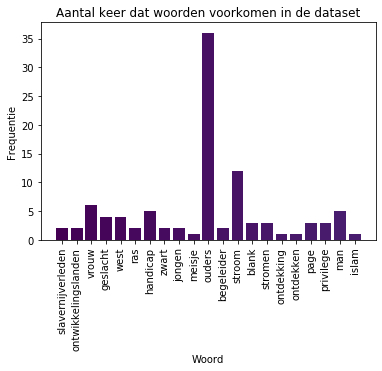

In [8]:
# leuk grafiekje van hoe vaak woorden voorkomen
word_freq = {}

for woord in dataset_zoek['word']:
    if woord in word_freq:
        word_freq[woord] += 1
    elif pd.isna(woord) == True:
        pass
    else:
        word_freq[woord] = 1
        
mycmap = plt.get_cmap("viridis").colors
        
plt.bar(word_freq.keys(), word_freq.values(), color = mycmap)
plt.xticks(rotation=90)
plt.xlabel('Woord')
plt.ylabel('Frequentie')
plt.title('Aantal keer dat woorden voorkomen in de dataset')
plt.show()

In [9]:
# laten we kijken naar specifieke zinnen
def vind_zinnen(woord):
    for i in range(len(dataset_zoek)):
        if dataset_zoek['word'].iloc[i] == woord:
            print(dataset_zoek['text'].iloc[i])
            print("DOCUMENT:")
            print(dataset_zoek['Onderwerp'].iloc[i])
            
vind_zinnen('blank')

Woord vooraf                                                                                    5
Begrippenlijst                                                                                  7
Samenvatting                                                                                    9
1           Inleiding                                                                          13
            1.1   Aanleiding                                                                   13
            1.2   Doel van het onderzoek                                                       13
            1.3   Aanpak                                                                       13
            1.4   Leeswijzer                                                                   14
2           Technische ruimte(n)                                                               15
            2.1   Installatie                                                                  15
            2.2   De

In [10]:
# Rapportage fase 1 dialoog SamenSpraak
# dit document splitsen in zinnen en beschikbaar maken voor labelling

# als de data wordt aangeleverd in paragraafformat
def generate_to_label_paragrafen(dataset, document = 'all'):
    if document == 'all':
        kolommen = ['document', 'text', 'zin']
        data = []
        paragrafen = []
        woorden = []

        # isolate sentences based on '.' or '!' or '?'
        for i in range(len(dataset_zoek)):
            # voorkomen dat paragrafen dubbel worden opgenomen
            paragraaf = dataset['text'].iloc[i]
            document = dataset['Onderwerp'].iloc[i]
            if paragraaf not in paragrafen:
                paragrafen.append(paragraaf)
                zinnen = paragraaf.split(sep = '.')

                for zin in zinnen:
                    data.append([document, paragraaf, zin])
        to_label = pd.DataFrame(data, columns = kolommen)
        return(to_label)
    
    else: #filter specifiek document
        kolommen = ['document', 'text', 'zin']
        data = []
        paragrafen = []
        woorden = []

        # isolate sentences based on '.' or '!' or '?'
        for i in range(len(dataset)):
            if dataset['Onderwerp'].iloc[i] == document:
                # voorkomen dat paragrafen dubbel worden opgenomen
                paragraaf = dataset['text'].iloc[i]
                document = dataset['Onderwerp'].iloc[i]
                if paragraaf not in paragrafen:
                    paragrafen.append(paragraaf)
                    zinnen = paragraaf.split(sep = '.')

                    for zin in zinnen:
                        data.append([document, paragraaf, zin])
        to_label = pd.DataFrame(data, columns = kolommen)
        return(to_label)

# als de data al is gesplitst in zinnen
def generate_to_label_zinnen(dataset, document = 'all'):
    if document == 'all':
        kolommen = ['document', 'text', 'zin']
        data = []
        paragrafen = []
        woorden = []

        # isolate sentences based on '.' or '!' or '?'
        for i in range(len(dataset_zoek)):
            # voorkomen dat paragrafen dubbel worden opgenomen
            zin = dataset_zoek['text'].iloc[i]
            document = dataset_zoek['Onderwerp'].iloc[i]

            # voeg voorgaande en opvolgende zin toe om context mee te geven
            if i == 0:
                paragraaf = dataset_zoek['text'].iloc[i] + dataset_zoek['text'].iloc[i+1]
            elif i == len(dataset_zoek):
                paragraaf = dataset_zoek['text'].iloc[i-1] + dataset_zoek['text'].iloc[i]
            else:
                paragraaf = dataset_zoek['text'].iloc[i-1] + dataset_zoek['text'].iloc[i] + dataset_zoek['text'].iloc[i+1]
            data.append([document, paragraaf, zin])
        to_label = pd.DataFrame(data, columns = kolommen)
        return(to_label)
    else:
        kolommen = ['document', 'text', 'zin']
        data = []
        paragrafen = []
        woorden = []

        # isolate sentences based on '.' or '!' or '?'
        for i in range(len(dataset_zoek)):
            if dataset_zoek['Onderwerp'].iloc[i] == document:
                # voorkomen dat paragrafen dubbel worden opgenomen
                zin = dataset_zoek['text'].iloc[i]
                document = dataset_zoek['Onderwerp'].iloc[i]

                # voeg voorgaande en opvolgende zin toe om context mee te geven
                if i == 0:
                    paragraaf = dataset_zoek['text'].iloc[i] + dataset_zoek['text'].iloc[i+1]
                elif i == len(dataset_zoek):
                    paragraaf = dataset_zoek['text'].iloc[i-1] + dataset_zoek['text'].iloc[i]
                else:
                    paragraaf = dataset_zoek['text'].iloc[i-1] + dataset_zoek['text'].iloc[i] + dataset_zoek['text'].iloc[i+1]
                data.append([document, paragraaf, zin])
        to_label = pd.DataFrame(data, columns = kolommen)
        return(to_label)
    
data_for_labelling = generate_to_label_paragrafen(dataset_zoek)
data_for_labelling['label'] = ''
data_for_labelling['score_annotator'] = ''
data_for_labelling['totaalscore'] = ''

# dummy: voeg synthetische score annotator + uiteindelijk label toe
def dummy_scores(dataset, dummy = False):
    if dummy == True:
        for i in range(len(dataset)):
            score = random.rand()
            dataset['score_annotator'].iloc[i] = score
            dataset['totaalscore'].iloc[i] = np.round(score)
    return dataset
            
data_for_labelling = dummy_scores(data_for_labelling, dummy = True)

display(data_for_labelling)

,document,text,zin,label,score_annotator,totaalscore
0,Beslisnota bij Kamerbrief over Geografische Ba...,...,...,,0.449565,0
1,Beslisnota bij Kamerbrief over Geografische Ba...,...,b,,0.125925,0
2,Beslisnota bij Kamerbrief over Geografische Ba...,...,t,,0.855116,1
3,Beslisnota bij Kamerbrief over Geografische Ba...,...,de\n Subsidieregelin...,,0.90922,1
4,Beslisnota bij Kamerbrief over Geografische Ba...,...,l,,0.238765,0
...,...,...,...,...,...,...
7177,Agenda Natuurinclusief 2.0,"We realiseren het ons niet dagelijks, maar nat...",\n VISUALISATIE COLLECTIEF NATUURINCLUSIE...,,0.223324,0
7178,Agenda Natuurinclusief 2.0,"We realiseren het ons niet dagelijks, maar nat...",Wij zorgen voor een ‘vruchtbare bodem’ met co...,,0.317717,0
7179,Agenda Natuurinclusief 2.0,"We realiseren het ons niet dagelijks, maar nat...",Dit doen we met ie-\n dereen samen,,0.761689,1
7180,Agenda Natuurinclusief 2.0,"We realiseren het ons niet dagelijks, maar nat...",Zie de visualisatie van de beweging natuurinc...,,0.146005,0


In [11]:
# voeg een sentiment analysis feature toe
pipe = pipeline("text-classification", model="wietsedv/bert-base-dutch-cased-finetuned-sentiment", return_all_scores=True)

negatives = 0
positives = 0
neutrals = 0

for i in range(len(data_for_labelling)):
    label = pipe(data_for_labelling.loc[i, 'zin'])
    neg_label = label[0][0]['score']
    pos_label = label[0][1]['score']
    if neg_label > pos_label:
        data_for_labelling['label'] = 'negatief'
        negatives += 1
    elif neg_label < pos_label:
        data_for_labelling['label'] = 'positief'
        positives +=1
    else:
        data_for_labelling['label'] = 'neutraal'
        neutrals += 1
        
print(positives, negatives, neutrals)

/data/milenadeswart/.local/lib/python3.7/site-packages/transformers/pipelines/text_classification.py:107: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  UserWarning,
Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


1219 5963 0


In [12]:
# optioneel: exporteer naar .csv
export_path = 'milenadeswart/share/Milena/programma-discriminatie-en-racisme/datasets/'
data_for_labelling.to_csv('dataset_dummy.csv')